In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plots
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import io
import os
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorboard.plugins.hparams import api as hp
from google.colab import drive

### Data Loading

In [2]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files = True,
                                  split=['train'])

In [3]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [4]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )

### data visualization

In [5]:
list(train_dataset.take(1).as_numpy_iterator())[0][0].shape

(145, 148, 3)

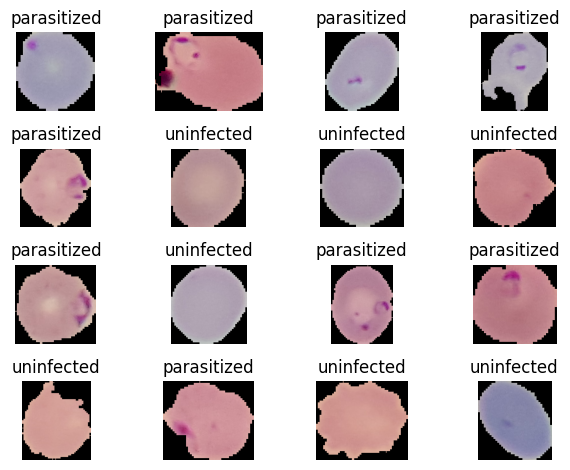

In [6]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)

  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')
plt.tight_layout()
plt.show()

### data augmentation

In [7]:
def visualize(original, augmented):
  plt.subplot(1,2,1)
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.imshow(augmented)

In [8]:
original_image, label = next(iter(train_dataset))
augmented_image = tf.image.adjust_saturation(original_image, saturation_factor = 0.3)#central_crop(original_image, 0.8)

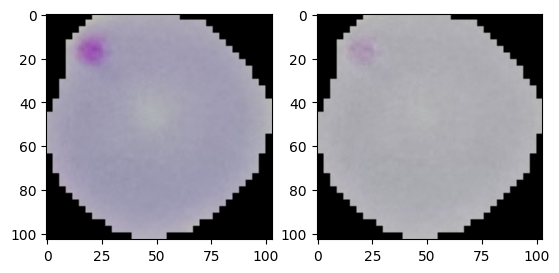

In [9]:
visualize(original_image, augmented_image)

In [10]:
IM_SIZE = 150

In [11]:
### tf.keras.layer resizing and rescaling
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255., label

### data preparation

In [ ]:
def augment(image, label):
  image = tf.image.random_brightness(image, 0.2)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.flip_left_right(image)
  return image, label

In [27]:
BATCH_SIZE=32
train_data = (
    train_dataset
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
val_data = (
    val_dataset
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [28]:
len(train_dataset)

22046

In [29]:
len(val_dataset)

2755

### training

In [30]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(150,150,3)),

    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=(
        1, 1), padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2), padding='valid'),

    tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=(
        1, 1), padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2), padding='valid'),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 146, 146, 6)       456       
                                                                 
 batch_normalization_8 (Bat  (None, 146, 146, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 73, 73, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 69, 69, 16)        2416      
                                                                 
 batch_normalization_9 (Bat  (None, 69, 69, 16)        64        
 chNormalization)                                                
                                                      

In [15]:
pip install -U tensorboard_plugin_profile

In [16]:
!rm -rf ./logs/

In [17]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
METRIC_DIR = './logs/' + CURRENT_TIME + '/metrics'
train_writer = tf.summary.create_file_writer(METRIC_DIR)

In [18]:
LOG_DIR = './logs/'+ CURRENT_TIME
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq = 1, profile_batch = '100,132')

In [31]:
model.compile(optimizer = Adam(learning_rate = 0.0001),
      loss = BinaryCrossentropy(),
      metrics = ['binary_accuracy'])

In [32]:
history = model.fit(
    train_data,
    validation_data = val_data,
    epochs = 23,
    verbose = 2,

    )

689/689 - 32s - loss: 0.0124 - binary_accuracy: 0.9957 - val_loss: 0.2824 - val_binary_accuracy: 0.9314 - 32s/epoch - 47ms/step


In [49]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [50]:
%reload_ext tensorboard

In [48]:
!kill 37767

/bin/bash: line 1: kill: (37767) - No such process


In [51]:
tensorboard --logdir='./logs'

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-12-04 14:13:31.267877: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 14:13:31.267983: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 14:13:31.268023: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 14:13:32.803974: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorf